In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyart
import pickle
import math as m


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def min_gate_num(ranges, min_i, min_f, th):
    
    coef= (1/th)*np.log(min_i/min_f)
    
    min_gate_num = np.full((len(ranges)), min_f)
    min_gate_num[np.where(ranges<th)] = np.floor(min_i*np.exp(-coef*ranges[np.where(ranges<th)]))
    
    return min_gate_num

In [3]:
def range_finder(labs, n_labs, ranges):
    
    max_ranges = np.zeros((n_labs+1,))
    
    for i in np.arange(0, len(ranges)-1):
        max_ranges[np.unique(labs[:,i])] = ranges[i]
        
    return max_ranges

In [4]:
def speckle_filter(data_ma, range_a, kernel=None, min_i=25, min_f=10, th=110):
        
    if kernel is None:
        kernel = np.zeros((3,3))
        np.put(kernel, [1,3,4,5,7], 1)
        
    mask = data_ma.mask.copy()
        
    labs, n_labs = sp.ndimage.label((~mask))
     
    # Number of gates in each group
    region_sizes = np.bincount(labs.ravel())
       
    max_ranges = range_finder(labs, n_labs, range_a)
    min_num = min_gate_num(max_ranges, min_i, min_f, th)

    mask = np.ones(labs.shape)
    for bg in np.where(region_sizes>min_num)[0]:
        mask[np.where(labs==bg)] = 0
    
    return mask, labs, n_labs


In [5]:
# Input and output directories
data_path = '/home/pav/repos/vilabella_140530/RESULTS_pkl/'
file_name = 'CDV1405301630_corr.pkl'
in_file = data_path + file_name

fig_size = [12, 10]
sweep = 0

# Load data
with open(in_file, "rb") as i_file:
    radar = pickle.load(i_file)
    
sw_slice = radar.get_slice(sweep)
# get data
data = radar.get_field(sweep, 'reflectivity')
old_mask = data.mask

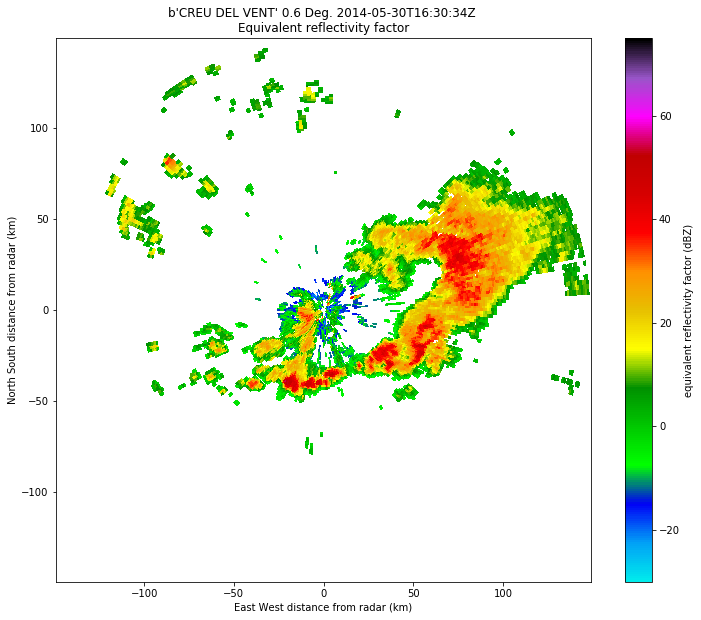

In [6]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)

display.plot('reflectivity', sweep=sweep, fig=fig,ax=ax)
plt.show()

In [7]:
# Define kernel with nearest neighbours
#k = np.zeros((3,3))
#np.put(k, [1,3,4,5,7],1)
k=np.ones((3,3))

In [8]:
ranges = np.round(radar.range['data']/1000) # in meters

In [11]:
mask, labs, n_labs = speckle_filter(data, ranges, kernel=k)

In [40]:
idx_r = np.where(labs>0)[1]
idx_r2 = np.logical_and(data != 9999, labs > 0)
gr_r = ranges[idx_r]
ranges[idx_r2[1]]

array([   7.,    8.,  114.,  115.,  116.,  117.], dtype=float32)

In [38]:
labs[idx_r]

array([  1,   1,   1, ..., 180, 180, 180], dtype=int32)

In [ ]:
new_mask = (old_mask) | (mask.astype(bool))

In [ ]:
data.mask = new_mask

In [ ]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)

display.plot('reflectivity', sweep=sweep, fig=fig,ax=ax)
plt.show()

In [21]:
radar.fields['reflectivity']['data'].shape

(2520, 148)